In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Summary

The point of this notebook is to develop better tree rooting algorithms. Develop, because this will be messy for the time being and will eventually split into hopefully comprehensible code when the time arises.

In [2]:
from Bio import Phylo, SeqIO
import numpy as np
from scipy import stats

import ete3
from io import StringIO
import random
from scipy.optimize import minimize, minimize_scalar
from matplotlib import pyplot as plt

import glob
import pandas as pd

import copy

# Test my MP algorithm

I'm confident that it works, at least on the trees I've tested. But I really need to demonstrate that here.

Note that I've uncovered weird problems with the `root_at_midpoint()` method from `Bio.Phylo`, so I won't be trusting it as a positive control. Rather, should demonstrate that they are usually equivalent and when there are discrepancies my method produces the expected behavior (conserving branch length, for instance).

In [3]:
import rooting_methods

In [ ]:
for input_tree in glob.glob('../Tria_et_al_data/cyanobacteria/ingroup/phyml/*.nwk')[:]:
    my_tree = Phylo.read(input_tree, 'newick', rooted=False)
    initial_terminals = my_tree.get_terminals()
    my_tree = rooting_methods.mp_root_adhock(my_tree)
    assert my_tree.is_bifurcating()
    my_bls = (my_tree.root.clades[0].branch_length, my_tree.root.clades[1].branch_length)
    my_bls = sorted(my_bls)
    phylo_tree = Phylo.read(input_tree, 'newick', rooted=False)
    phylo_tree.root_at_midpoint()
    phylo_bls = (phylo_tree.root.clades[0].branch_length, phylo_tree.root.clades[1].branch_length)
    phylo_bls = sorted(phylo_bls)

**Investigate example errors**

**The ete3 method is just plain wrong**

In [ ]:
# tree_loc = '../test.ete3.newick'
# # tree_loc = '/Users/adamhockenberry/Projects/Phylogenetic_couplings/scratch/current/1AOE_A_rp75.newick'
# tree = ete3.Tree(tree_loc)
# outgroup = tree.get_midpoint_outgroup()
# tree.set_outgroup(outgroup)
# tree.render('%%inline')

** Add in a comparison to DendroPy to be comprehensive **

# Testing method based off of minimizing the standard deviation in the distribution of root-to-tip distances

...this is surprisingly easy and seems like it should work great...I guess it's just the Min-var or MCCV method as it's called in the MAD paper? Not sure if maximizing the likelihood of a gaussian is the sme as minimizing the coefficient of variation but I'm kind of guessing yes. And in any event this code is easily adapted

In [ ]:
import rooting_methods
import rooting_methods_v2

In [ ]:
# tree = Phylo.read('../../Tree_rooting/Data/raw_OMA_trees/OMAGroup_479938.mafft.afa.treefile.Rooted.MPAJH', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
# rooted_tree.root_with_outgroup(['ELI', 'MAL'], outgroup_branch_length=10e-6)
# tree = Phylo.read(StringIO('(((A:20, B:20):30,C:50):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../../Tree_rooting/Data/euk_trees/KOG0001.faa.aln.nwk.Rooted.MADAJH', 'newick')
tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
rooted_tree = rooting_methods.mp_root_adhock(tree)
# Phylo.draw(rooted_tree)

In [ ]:
%%timeit
a1, b1, c1 = rooting_methods.ml_root_adhock(rooted_tree)

In [ ]:
%%timeit
a2, b2, c2 = rooting_methods_v2.mlfit_root_adhock(rooted_tree)

# Testing systematically

In [ ]:
id_species_dict = {}
with open('../Tria_et_al_data/eukaryotes/ID_to_Species.txt', 'r') as infile:
    texty = infile.readlines()
    for line in texty[1:]:
        sl = line.split('\t')
        id_species_dict[sl[0]] = sl[1]
print(len(id_species_dict.keys()))

species_seqid_dict = {}
with open('../Tria_et_al_data/eukaryotes/cluster_to_seqid.txt', 'r') as infile:
    texty = infile.readlines()
    for line in texty:
        sl = line.split('\t')
        if sl[0] == 'KOG0725':
            species_seqid_dict[sl[1]] = sl[2].strip()
print(len(species_seqid_dict.keys()))

In [ ]:

# fungi = ['13684', ]
# id_species_dict

** test monophyly **

In [ ]:
def recursive_tree_monophyly(hypothetical_root, tree, test_set, is_mono):
    if tree.is_monophyletic(test_set):
        is_mono = True
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades
        if l_clade.branch_length > 0:
            tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
            is_mono = recursive_tree_monophyly(l_clade, tree, test_set, is_mono)
            is_mono = recursive_tree_monophyly(r_clade, tree, test_set, is_mono)
        elif r_clade.branch_length > 0:
            tree.root_with_outgroup(r_clade, outgroup_branch_length=10e-10)
            is_mono = recursive_tree_monophyly(l_clade, tree, test_set, is_mono)
            is_mono = recursive_tree_monophyly(r_clade, tree, test_set, is_mono)
    elif len(hypothetical_root.clades) == 1:
        l_clade = hypothetical_root.clades[0]
        if l_clade.branch_length > 0:
            tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
            is_mono = recursive_tree_monophyly(l_clade, tree, test_set, is_mono)
    elif len(hypothetical_root.clades) == 0:
        return is_mono
    return is_mono

# tree.get_terminals()
# tree.is_monophyletic(metazoa)
tree = Phylo.read('../test.ete3.newick', 'newick', rooted=False)
tree = mp_root_adhock(tree)
# tree.is_monophyletic([term for term in tree.get_terminals() if\
#                       term.name in ['7165', '7425', '7460', '121225', '7227', '6239']])

In [ ]:
testy = [term for term in tree.get_terminals() if\
                      term.name in metazoa]
recursive_tree_monophyly(tree.root, tree, testy, False)

In [ ]:
Phylo.draw(tree)

In [ ]:
metazoa = ['10090', '121225', '9606', '30611', '8364', '7955', '8128', '8090',\
          '7668', '7460', '7425', '7227', '7165', '6239']
problematic = ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG3467.faa.aln.nwk',\
              '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2866.faa.aln.nwk']

trees_dir = '../Tria_et_al_data/eukaryotes/ingroup/phyml/*.nwk'
ideal_species_number = 31

# n_pruned = 15
# trees_dir = '../Tria_et_al_data/eukaryotes/ingroup/phyml/*.{}.pruned'.format(n_pruned)
# problematic = [i+'.{}.pruned'.format(n_pruned) for i in problematic]
# # problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2688.faa.aln.nwk.6.pruned']
# problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG3887.faa.aln.nwk.15.pruned']
# problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1374.faa.aln.nwk.15.pruned']
# problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1558.faa.aln.nwk.15.pruned']
# problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0284.faa.aln.nwk.15.pruned']
# problematic += ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0594.faa.aln.nwk.15.pruned']
# ideal_species_number = 31-n_pruned


# trees_dir = ['../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk']
mp_success_rate = 0
ml_success_rate = 0
mad_success_rate = 0
attempts = 0
for tree_loc in glob.glob(trees_dir)[:50]:
    if tree_loc in problematic:
        continue
    print('######## {}'.format(tree_loc))
    tree = Phylo.read(tree_loc, 'newick')
    if len(tree.get_terminals()) != ideal_species_number:
        continue
        
    try:
        mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
    except ValueError:
        print('MAD did not work here')
        continue

    testy = [term for term in tree.get_terminals() if\
                      term.name in metazoa]
    rooted_tree = mp_root_adhock(tree)
    valid = recursive_tree_monophyly(rooted_tree.root, rooted_tree, testy, False)
    if valid:
        attempts += 1
        ###Mid point
        mp_tree = mp_root_adhock(tree)
        if set(testy) == set(mp_tree.root.clades[0].get_terminals()) or \
            set(testy) == set(mp_tree.root.clades[1].get_terminals()):
                mp_success_rate += 1
        ###ML        
        ml_tree = max_likelihood_root(tree)
        if set(testy) == set(ml_tree.root.clades[0].get_terminals()) or \
            set(testy) == set(ml_tree.root.clades[1].get_terminals()):
                ml_success_rate += 1
        ###MAD
        testy = [term for term in mad_tree.get_terminals() if\
                      term.name in metazoa]
        if set(testy) == set(mad_tree.root.clades[0].get_terminals()) or \
            set(testy) == set(mad_tree.root.clades[1].get_terminals()):
                mad_success_rate += 1
#     tree.root_at_midpoint()
#     print(min([term.branch_length for term in tree.get_terminals()]))
#     print(recursive_tree_monophyly(tree.root, tree, testy, False))
    print(mp_success_rate, mad_success_rate)


    

In [ ]:
mp_success_rate / attempts, ml_success_rate / attempts, mad_success_rate / attempts

In [ ]:
# Phylo.draw(tree)
# Phylo.draw(mp_tree)
# Phylo.draw(ml_tree)
# Phylo.draw(mad_tree)

In [ ]:
mp_success_rate, ml_success_rate, mad_success_rate, attempts

In [ ]:
tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG3467.faa.aln.nwk'
tree = Phylo.read(tree_loc, 'newick')

# tree.root_at_midpoint()
tree = mp_root_adhock(tree)
Phylo.draw(tree)

In [ ]:
# testy = [term for term in tree.get_terminals() if\
#                       term.name in metazoa]
recursive_tree_monophyly(tree.root, tree, testy, False)

In [ ]:
tree.get_terminals()

# A weighted MaxLik implementation

In [8]:
from Bio import Phylo
import rooting_methods, rooting_methods_weighted

import pandas as pd
import numpy as np

from scipy.optimize import minimize
from scipy import stats

from statsmodels.stats.weightstats import DescrStatsW

In [9]:
import sys
sys.path.append('../../Tree_weighting/Code/')
import weighting_methods

In [ ]:
def update_GSC_raw(my_clade, parent_clade, weights_dict, finished):
    """    
    This is pretty convoluted and could perhaps be simplified greatly with more thought. A lot of steps
    but should be linear in O(t). The goal/purpose is to not have to re-calculate GSC weights for each 
    possible root location. Rather, calculate these values once at the starting root node and then 
    apply this function when recursively crawling the tree.
    
    Input/s:
    my_clade - just a Bio.Phylo clade object
    parent_clade - the parent of the relevant clade
    weights_dict - the existing dictionary of clade(key):weights matrix(value) pairs
    finished - a list of the terminals that have been completed (used for rapidly accessing
                the downstream and upstream terminals)
                
    Output/s:
    weights_dict - the updated weights_dict object with a new key:val pair added to it
    
    """
    #Get number of downstream terminals
    ds_count = len(my_clade.get_terminals())
    #Copy matrix from parent
    new_array = np.array(weights_dict[parent_clade])
    #This is the total "weight" to reclaim from the downstream terms and distribute to the upstreams
    bl_to_disperse = my_clade.branch_length
    assert np.isclose(bl_to_disperse, np.sum(new_array[len(finished):len(finished)+ds_count, -1])-\
                                    np.sum(new_array[len(finished):len(finished)+ds_count, -2]))
    
    #Get the total current weight of all upstream terms
    to_divide = np.sum(new_array[:,-1]) - np.sum(new_array[len(finished):len(finished)+ds_count, -1])
    #Array of values to add to the first and second set of upstream terms
    to_add_a = new_array[:len(finished),-1]/to_divide * bl_to_disperse + new_array[:len(finished),-1]
    to_add_b = new_array[len(finished)+ds_count:,-1]/to_divide * bl_to_disperse + new_array[len(finished)+ds_count:,-1]
    
    #Subtract the values from the downstream terms by rolling the values over
    new_array[len(finished):len(finished)+ds_count] =\
                np.roll(new_array[len(finished):len(finished)+ds_count], 1, axis=1)
    #And setting the first column to be zeros
    new_array[len(finished):len(finished)+ds_count, 0] = 0
    #Finally, append now column of zeros
    new_array = np.append(new_array, np.zeros([len(new_array),1]), axis=1)
    #Roll the downstream terms again
    new_array[len(finished):len(finished)+ds_count] =\
                np.roll(new_array[len(finished):len(finished)+ds_count], 1, axis=1)
    #Append the new vals for both upstream term setes
    new_array[:len(finished),-1] = to_add_a
    new_array[len(finished)+ds_count:,-1] = to_add_b
    #et voila
    weights_dict[my_clade] = new_array   
    return weights_dict

def update_depth_array_dict(my_clade, parent_clade, depths_dict, finished):
    """
    This function updates the depths of each terminal in a pretty straightforward manner.
    
    Input/s:
    my_clade - Bio.Phylo clade object
    parent_clade - parent of my_clade
    depths_dict - the exsting dictionary of depths where: clade(key):array of depths (value)
    finished - a list of all the terminals that have been completed in the depth first search
    
    Output/s:
    depths_dict - the updated depths_dict
    ds_count - the number of terminals downstream of this particular clade
    
    """
    #First grab who is downstream of this new clade
    ds_count = len(my_clade.get_terminals())
    #Instantiate new array with values from parent
    new_array = np.array(depths_dict[parent_clade])
    #Subtract the branch length from all the downstream clades
    new_array[len(finished):len(finished)+ds_count] -= my_clade.branch_length
    #Add the branch length to all the upstream clades (two sets)
    new_array[:len(finished)] += my_clade.branch_length
    new_array[len(finished)+ds_count:] += my_clade.branch_length
    #Update the dictionary
    depths_dict[my_clade] = new_array
    return depths_dict, ds_count

def MinVar_root_adhock_GSC(tree, normalize_GSC=False):
    ''' 
    This implements a rooting scheme to minimize the weighted standard deviation of the root-to-tip
    distances for all leaves in the tree. It is unclear whether minimizing the variance of a non-normal
    distribution would be more appropriate but this could easily be accommodated within this framework.
    
    Input/s:
    tree - a Bio.Phylo tree object (in practice I like to root the tree with my basic mid-point 
                algorithm first just to ensure that the tree structure is normal-ish, i.e. bifurcating)
    normalize_GSC - boolean of whether or not to re-scale the GSC weights in the final step
                
    Output/s:
    tree - the now rooted tree object
    function_optima - a list of all the function optimization output for each putative root tested
    depths_dict - a dictionary of the depths for each terminal for each putative root where: 
                clade(key): array of weights for all terminals (value)
    weights_dict - a dictionary of the weights for each terminal for each putative root where:
                clade(key): matrix of weights for all terminals (value), final column are 
                the relevant weights but the entire matrix is necessary for rapid updating

    '''
    initial_depths = tree.root.depths()
    #Instantiate a depths dictionary with the root node
    depths_dict = {}
    depths_dict[tree.root] = np.array([initial_depths[i] for i in tree.get_terminals()])
        
    initial_weights = weighting_methods.GSC_adhock(tree)
    #Instantiate a weights dictionary with the root node
    weights_array_dict = {}
    weights_array_dict[tree.root] = np.array([initial_weights[i] for i in tree.get_terminals()])
    #Do a lot of work! Recursively crawl the tree visiting each possible root branch
    function_optima, depths_dict, weights_dict, finished =\
            recursive_crawl_MinVar(tree.root, None, [], depths_dict, weights_array_dict, [], normalize_GSC) 
    #Sort the output by the function value to find the minimum    
    function_optima = sorted(function_optima, key=lambda x: x[1].fun)
    #Re-root at this point 
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=0.)
    assert tree.root.clades[1].branch_length == 0.
    assert tree.root.clades[1] == function_optima[0][0]
    #And adjust the branch lengths around this root
    tree.root.clades[0].branch_length -= function_optima[0][1].x[0]
    tree.root.clades[1].branch_length += function_optima[0][1].x[0]
    return tree, function_optima, depths_dict, weights_dict

def recursive_crawl_MinVar(my_clade, parent_clade, function_optima, depths_dict,\
                           weights_dict, finished, normalize_GSC):
    """
    This is a meaty recursive function that performs the depth first search / tree crawling.
    
    Input/s:
    my_clade - Bio.Phylo clade object
    parent_clade - the parent of my_clade
    function_optima - list of all the function_optima that I'm calculating
    depths_dict - described in detail elsewhere
    weights_dict - described in detail elsewhere
    finished - list of all terminals that the depth first search has completed
    normalize_GSC - boolean of whether or not to re-scale the GSC values

    Output/s (updated versions of each of):
    function_optima
    depths_dict
    weights_dict
    finished
    
    """
    #If the node has a parent, do some calculations (this is here just to skip calculations on the root
    if parent_clade:
        #Update the depths dictionary
        depths_dict, ds_count = update_depth_array_dict(my_clade, parent_clade, depths_dict, finished)
        #Update the weights dictionary
        weights_dict = update_GSC_raw(my_clade, parent_clade, weights_dict, finished)
        #Minimize the variance with these values
        res = optimize_root_loc_on_branch_MinVar(my_clade, depths_dict[my_clade],\
                                                 weights_dict[my_clade], ds_count, finished, normalize_GSC)
        #Append
        function_optima.append((my_clade, res))
    ###Recurse (i.e. depth first search)
    if len(my_clade.clades) == 2:
        l_clade, r_clade = my_clade.clades
        function_optima, depths_dict, weights_dict, finished =\
                recursive_crawl_MinVar(l_clade, my_clade, function_optima,\
                                      depths_dict, weights_dict, finished, normalize_GSC)
        function_optima, depths_dict, weights_dict, finished =\
                recursive_crawl_MinVar(r_clade, my_clade, function_optima,\
                                      depths_dict, weights_dict, finished, normalize_GSC)
    elif len(my_clade.clades) == 0:
        #This is quite critical, once I reach a node with no clades I'm finished so begin to 
        #backtrack and keep track of how many I've completed
        finished.append(my_clade)
        return function_optima, depths_dict, weights_dict, finished
    else:
        print('Some big error here with the number of clades stemming from this root')
    return function_optima, depths_dict, weights_dict, finished



def optimize_root_loc_on_branch_MinVar(my_clade, depths_array, weights_array, ds_count, finished, normalize_GSC):
    """
    For a given branch, ths will take the depths and weights and optimize the exact location
    of the root for that particular branch.
    
    Input/s:
    my_clade - Bio.Phylo clade object
    depths_array - 1D numpy array of all the depths for each terminal
    weights_array - 2D numpy array of all the weights for each terminal (last column counts)
    ds_count - number of downstream terminals emanating from this clade
    finished - list of all completed terminals during the depth first search
    
    Output/s:
    res - the function optima (scipy.optimize object)
    
    """
    #Root-to-tip distances for all downstream terminals
    downstream_dists = np.array(depths_array[len(finished):len(finished)+ds_count])
    #And all upstream terminals
    upstream_dists = np.concatenate((depths_array[:len(finished)],\
                                     depths_array[len(finished)+ds_count:]))
    
    #Weights for all downstream terminals
    downstream_weights = np.array(weights_array[len(finished):len(finished)+ds_count, -1])
    #And all upstream terminals
    upstream_weights = np.concatenate((weights_array[:len(finished), -1],\
                                       weights_array[len(finished)+ds_count:, -1]))
    #Also will need to know the old weights for upstream folks which should be the second to last column
    old_upstream_weights = np.concatenate((weights_array[:len(finished), -2],\
                                           weights_array[len(finished)+ds_count:, -2]))
    #Set the bounds for the optimization
    bl_bounds = np.array([[0., my_clade.branch_length]])
    #Valid options for method are L-BFGS-B, SLSQP and TNC
    res = minimize(branch_scan_MinVar, np.array(np.mean(bl_bounds)),\
                          args=(downstream_dists, upstream_dists,\
                                downstream_weights, upstream_weights, old_upstream_weights, normalize_GSC),\
                          bounds=bl_bounds, method='SLSQP')
    return res 


    
def branch_scan_MinVar(modifier, ds_dists, us_dists, ds_weights, us_weights, old_us_weights, normalize_GSC=False):
    """
    Should really try to make this a bit quicker/simpler if possible. All array options but a bit too
    many I suspect.
    
    Input/s:
    modifier - This is the parameter to be optimized! Essentially a float of how much to shift the
                root left or right so as to minimize the root-to-tip variance
    ds_dists - array of downstream root-to-tip distances
    us_dists - array of upstream root-to-tip distances
    ds_weights - array of downstream terminal weights
    us_weights - array of upstream terminal weights
    old_us_weights - array of upstream terminal weights at the last step
    
    Output/s:
    dsw.std - weighted standard deviation
    
    """
    #Adjust the downstream and upstream root-to-tip distances with the modifier
    temp_ds_dists = ds_dists + modifier
    temp_us_dists = us_dists - modifier
    all_dists = np.concatenate((temp_ds_dists, temp_us_dists))
    #Get the total down stream weights
    total_ds = np.sum(ds_weights)
    #Divide up the added branch length (modifier) across the downstream weights
    if total_ds != 0:
        temp_ds_weights = ds_weights + (ds_weights/total_ds*modifier)
    #Special case if nothing is downstream (for terminal branches)
    else:
        temp_ds_weights = ds_weights + modifier
    #Get the total old upstream weights
    total_us = np.sum(old_us_weights)
    #Reclaim the branch length (modifier) from all the upstream weights
    if total_us != 0:
        temp_us_weights = us_weights - (old_us_weights/total_us*modifier)
    #Special case for terminal branches
    else:
        temp_us_weights = us_weights - modifier
    #Put all the weights together
    all_weights = np.concatenate((temp_ds_weights, temp_us_weights))
    
    if normalize_GSC:
        all_weights = all_weights/all_dists
    #Assertion should work but can be a bit annoying for very minor differences (np.isclose) so is commented
    #while I decide whether to deal with it or not
    #assert np.all(all_dists - all_weights >= 0), print(all_dists,'\n', all_weights, '\n', all_dists-all_weights)
    
    #Calculate weighted variance and return
    dsw = DescrStatsW(all_dists, all_weights)
    return dsw.var

In [ ]:
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
tree = Phylo.read(StringIO('(((A:20, B:20):30,C:20):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../Data/Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0007.faa.aln.nwk', 'newick')
# Phylo.draw(tree)
# tree.root_with_outgroup('A', outgroup_branch_length=10e-8)
# C = next(tree.find_elements('C'))
# C.branch_length = 40
# tree.root_with_outgroup('MAL')
# noi = next(tree.find_elements('PV22'))
# noi.branch_length += 20
Phylo.draw(tree)

In [ ]:
tree = rooting_methods.mp_root_adhock(tree)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
tree, a, b, c = MinVar_root_adhock_GSC(tree, normalize_GSC=False)
# tree, a, b, c = MinVar_root_adhock_GSC(tree, normalize_GSC=True)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])

In [ ]:
tree = rooting_methods.mp_root_adhock(tree)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
tree, a, b = rooting_methods.mlfit_root_adhock(tree)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])

# Faster/Cleaner GSC going from root-to-tip

In [4]:
import rooting_methods_general

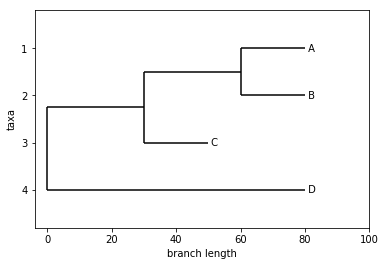

In [33]:
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
tree = Phylo.read(StringIO('(((A:20, B:20):30,C:20):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../Data/Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0007.faa.aln.nwk', 'newick')
# Phylo.draw(tree)
# tree.root_with_outgroup('A', outgroup_branch_length=10e-8)
# C = next(tree.find_elements('C'))
# C.branch_length = 40
# tree.root_with_outgroup('MAL')
# noi = next(tree.find_elements('PV22'))
# noi.branch_length += 20
Phylo.draw(tree)

Potential for multiple midpoints. Choosing the first that I encounter


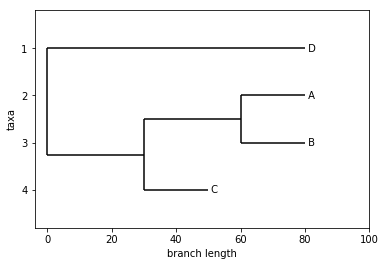

[('D', 80.0), (None, 30.0)]


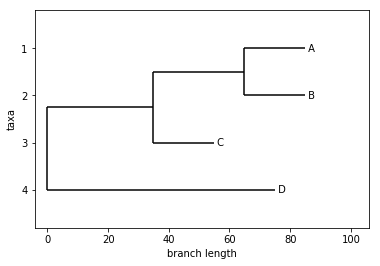

[(None, 34.886254668129624), ('D', 75.113745331870376)]


In [35]:
tree = rooting_methods_general.mp_root_adhock(tree)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
tree, a, b, c = rooting_methods_general.MinVar_root_adhock_general(tree, weights_type='GSCn')
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])

# HH weights...

In [4]:
import rooting_methods_general

In [35]:
tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
fasta_loc = '../../Phylogenetic_couplings/Data/psicov150_aln_pdb/aln_fasta_max1k/1a3aA.fasta'
# tree = Phylo.read('../Data/Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0007.faa.aln.nwk', 'newick')
# seq_records = list(SeqIO.parse('../Data/Tria_et_al_data/eukaryotes/ingroup/aln/KOG0007.faa.aln', 'fasta'))
# Phylo.draw(tree)
# tree.root_with_outgroup('A', outgroup_branch_length=10e-8)
# C = next(tree.find_elements('C'))
# C.branch_length = 40
# tree.root_with_outgroup('MAL')
# noi = next(tree.find_elements('PV22'))
# noi.branch_length += 20

In [23]:
# tree = rooting_methods.mp_root_adhock(tree)
# # Phylo.draw(tree)
# print([(i.name, i.branch_length) for i in tree.root.clades])
# print([len(i.get_terminals()) for i in tree.root.clades])
# tree, a, b = rooting_methods.MinVar_root_adhock(tree)
# # Phylo.draw(tree)
# print([(i.name, i.branch_length) for i in tree.root.clades])
# print([len(i.get_terminals()) for i in tree.root.clades])

In [10]:
tree = rooting_methods.mp_root_adhock(tree)
# Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
tree, a, b, c = rooting_methods_weighted.MinVar_root_adhock_GSC(tree, normalize_GSC=False)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
tree, a, b, c = rooting_methods_weighted.MinVar_root_adhock_GSC(tree, normalize_GSC=True)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
tree, a, b, c = rooting_methods_weighted.MinVar_root_adhock_HH(tree, seq_records)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
# Phylo.draw(tree)


[(None, 0.14757790099999971), (None, 0.0017717700000002834)]
[338, 663]
[(None, 0.14092611013637613), (None, 0.068305607863623885)]
[339, 662]
[(None, 0.074901747726326351), (None, 0.13432997027367366)]
[662, 339]
[(None, 0.16073029486167412), (None, 0.048501423138325887)]
[339, 662]


/Users/adamhockenberry/Projects/Tree_rooting/Code/rooting_methods_weighted.py:287: RuntimeWarning: invalid value encountered in true_divide
  all_weights = all_weights/all_dists


In [37]:
tree = rooting_methods.mp_root_adhock(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
#
tree, a, b, c = rooting_methods_general.MinVar_root_adhock_general(tree, weights_type=None)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
#
tree, a, b, c = rooting_methods_general.MinVar_root_adhock_general(tree, weights_type='GSC')
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
#
tree, a, b, c = rooting_methods_general.MinVar_root_adhock_general(tree, weights_type='GSCn')
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])
#
tree, a, b, c = rooting_methods_general.MinVar_root_adhock_general(tree,\
                                                              weights_type='HH',\
                                                              **{'fasta_loc':fasta_loc})
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])

[(None, 0.14757790099999971), (None, 0.0017717700000002834)]
[338, 663]
[(None, 0.0030744883664457767), (None, 0.08158672963355422)]
[542, 459]
[(None, 0.068305623873945231), (None, 0.14092609412605478)]
[662, 339]
[(None, 0.074901747243664774), (None, 0.13432997075633524)]
[662, 339]
[(None, 0.16073029369128605), (None, 0.048501424308713965)]
[339, 662]


In [38]:
a[:5]

[(Clade(),
        fun: 0.25019052642864814
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.11022302e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 2
   status: 0
  success: True
        x: array([ 0.04850142])),
 (Clade(),
        fun: 0.25080570622631371
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04660397])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([ 0.13432997])),
 (Clade(branch_length=0.069914052),
        fun: 0.25226683990640703
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06330436])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([ 0.06991405])),
 (Clade(),
        fun: 0.25226683990640708
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([

In [ ]:
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])

In [ ]:
tree = rooting_methods.mp_root_adhock(tree)
tree, a, b = rooting_methods_weighted.mad_root_adhock(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
print([len(i.get_terminals()) for i in tree.root.clades])

# A weighted MAD... ugh

In [ ]:
import rooting_methods

In [ ]:
def mad_root_weighted(tree):
    for node in tree.get_terminals() + tree.get_nonterminals():
        if node == tree.root:
            continue
        if node.branch_length == 0.:
            node.branch_length = 10e-16
    dist_df = get_lca_dist_df(tree)
    tempy_dict = {}
    tempy_dict[tree.root] = dist_df
    explored, function_optima, lca_dist_df_dict = recursive_crawl_mad(tree.root, [], [], tree, tempy_dict)
    function_optima = sorted(function_optima, key=lambda x: x[1][1])
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=0.)
    tree.root.clades[0].branch_length -= function_optima[0][1][0]
    tree.root.clades[1].branch_length += function_optima[0][1][0]
    RAI = function_optima[0][1][1] / function_optima[1][1][1]
    return tree, RAI, function_optima


def get_lca_dist_df(tree):
    ''' 
    Where distance matrix here is subtle. I'm actually calculating the distance to LCA for an initial 
    hypothetical bifurcating root.
    '''
    assert tree.is_bifurcating()
    initial = np.zeros((len(tree.get_terminals()),len(tree.get_terminals())))
    #Call recursive function
    recurse, finished_list = recursive_clade(initial, tree.root, finished=[])
    final = recurse - recurse.diagonal()
    term_names = [i.name for i in tree.get_terminals()]
    final_df = pd.DataFrame(final, index=term_names, columns=term_names)
    return final_df

def recursive_clade(vcv_matrix, initial_clade, finished=[]):
    ''' 
    This is kind of complicated looking but it should scale linearly with tree size
    '''
    if len(initial_clade) == 2:
        #Add branch length to relevant cells in matrix and move down the left side
        if not set(initial_clade[0].get_terminals()).issubset(set(finished)):
            clade = initial_clade[0]
            clade_term_n = len(clade.get_terminals())
            finished_n = len(finished)
            vcv_matrix[finished_n:finished_n+clade_term_n, finished_n:finished_n+clade_term_n] += clade.branch_length
            vcv_matrix, finished = recursive_clade(vcv_matrix, clade, finished)
        #Add branch length to relevant cells in matrix and move down the right side
        if not set(initial_clade[1].get_terminals()).issubset(set(finished)):
            clade = initial_clade[1]
            clade_term_n = len(clade.get_terminals())
            finished_n = len(finished)
            vcv_matrix[finished_n:finished_n+clade_term_n, finished_n:finished_n+clade_term_n] += clade.branch_length
            vcv_matrix, finished = recursive_clade(vcv_matrix, clade, finished)
    elif len(initial_clade) == 0:
        finished.append(initial_clade)
    else:
        print("ERROR: APPEARS TO BE A NON-BINARY TREE. MATRIX GENERATION WILL PROBABLY FAIL")
    return vcv_matrix, finished

def recursive_crawl_mad(hypothetical_root, explored, function_optima, tree, lca_dist_df_dict):
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades
        ###Recurse on l clade
        lca_dist_df_dict, my_terms, other_terms = update_lca_dist_df_dict(lca_dist_df_dict, l_clade, hypothetical_root, tree)
        res = mad_from_df(l_clade, my_terms, other_terms, lca_dist_df_dict[l_clade])
        function_optima.append((l_clade, res))
        explored, function_optima, lca_dist_df_dict = recursive_crawl_mad(l_clade, explored, function_optima, tree, lca_dist_df_dict)
        ###Recurse on r clade
        lca_dist_df_dict, my_terms, other_terms = update_lca_dist_df_dict(lca_dist_df_dict, r_clade, hypothetical_root, tree)
        res = mad_from_df(r_clade, my_terms, other_terms, lca_dist_df_dict[r_clade])
        function_optima.append((r_clade, res))
        explored, function_optima, lca_dist_df_dict = recursive_crawl_mad(r_clade, explored, function_optima, tree, lca_dist_df_dict)
    elif len(hypothetical_root.clades) == 0:
        explored.append(hypothetical_root)
        return explored, function_optima, lca_dist_df_dict
    else:
        print('non binary tree...?')
    explored.append(hypothetical_root)
    return explored, function_optima, lca_dist_df_dict

def update_lca_dist_df_dict(lca_dist_df_dict, my_clade, parent, my_tree):
    bl = my_clade.branch_length
    downstream_terms = [i.name for i in my_clade.get_terminals()]
    upstream_terms = list(set([i.name for i in my_tree.get_terminals()]) - set(downstream_terms))
    lca_dist_df = lca_dist_df_dict[parent].copy(deep=True)
    lca_dist_df.loc[downstream_terms,upstream_terms] -= bl
    lca_dist_df.loc[upstream_terms,downstream_terms] += bl
    lca_dist_df_dict[my_clade] = lca_dist_df
    return lca_dist_df_dict, downstream_terms, upstream_terms

def mad_from_df(my_clade, my_terms, other_terms, lca_dist_df):
    '''
    Need to document this
    '''
    print('###########')
    my_df = lca_dist_df.loc[my_terms, my_terms]
    other_df = lca_dist_df.loc[other_terms, other_terms]
    my_df_trans = my_df.T
    other_df_trans = other_df.T
    print(my_df_trans)
    print(other_df_trans)
    #Dealing with same side pairs
    ss_a_dists = np.abs(np.concatenate((my_df.values[np.triu_indices(len(my_terms), k = 1)],\
                                other_df.values[np.triu_indices(len(other_terms), k = 1)])))
    ss_b_dists = np.abs(np.concatenate((my_df_trans.values[np.triu_indices(len(my_terms), k = 1)],\
                                other_df_trans.values[np.triu_indices(len(other_terms), k = 1)])))
    print(ss_a_dists, ss_b_dists)
    ss_total_dists = ss_a_dists + ss_b_dists
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)
    print(ss_devs)
    #Dealing with different side pairs
    ds_a_dists = lca_dist_df.loc[my_terms, other_terms].values.flatten(order='C')
    ds_b_dists = lca_dist_df.loc[other_terms, my_terms].values.flatten(order='F')
    ds_total_dists = ds_a_dists + ds_b_dists

    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    total_bl = my_clade.branch_length
    if total_bl > 0.:
        rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
        modifier = total_bl*rho
        modifier = min(max(0, modifier), total_bl)
    else:
        modifier = 0.

    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)

    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final MAD score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)




In [ ]:
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
tree = Phylo.read(StringIO('(((A:20, B:20):30,C:50):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../../Tree_rooting/Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0007.faa.aln.nwk', 'newick')
# Phylo.draw(tree)
# tree.root_with_outgroup('A', outgroup_branch_length=10e-8)
# C = next(tree.find_elements('C'))
# C.branch_length = 40
# tree.root_with_outgroup('MAL')
# noi = next(tree.find_elements('PV22'))
# noi.branch_length += 20
# Phylo.draw(tree)

In [ ]:
tree = rooting_methods.mp_root_adhock(tree)
Phylo.draw(tree)
print([(i.name, i.branch_length) for i in tree.root.clades])
tree, a, b = mad_root_weighted(tree)
# Phylo.draw(tree)
# print([(i.name, i.branch_length) for i in tree.root.clades])

In [ ]:
import numpy

In [ ]:
tree.depths()

In [ ]:
for i, terminal_a in enumerate(tree.get_terminals()):
    for j, terminal_b in enumerate(tree.get_terminals()):
        if j >= i:
            continue
        path = [terminal_a] + tree.trace(terminal_a, terminal_b)
        ca = tree.common_ancestor(terminal_a, terminal_b)
        if ca.branch_length:
            path_len = np.sum([edge.branch_length for edge in path if edge.branch_length]) - ca.branch_length
        else: 
            path_len = np.sum([edge.branch_length for edge in path if edge.branch_length])
        print(terminal_a, terminal_b, path_len)

In [ ]:
testy = get_lca_dist_df(tree)

In [ ]:
testy

In [ ]:
all_paths = []

In [ ]:
df = pd.DataFrame(index=['AB', 'AC', 'AD', 'BC', 'BD', 'CD'],\
                  columns=['AB', 'AC', 'AD', 'BC', 'BD', 'CD'], dtype=float)

In [ ]:
for i in df.index:
    df.set_value(i, i, 1.)
pairs = [['AB', 'AC', 0.1],\
         ['AB', 'AD', 0.0625],\
         ['AB', 'BC', 0.1],\
         ['AB', 'BD', 0.0625],\
         ['AB', 'CD', 0.],\
         ['AC', 'AD', 0.15625],\
         ['AC', 'BC', 0.64],\
         ['AC', 'BD', 0.05625],\
         ['AC', 'CD', 0.15625],\
         ['AD', 'BC', 0.05625],\
         ['AD', 'BD', 0.765625],\
         ['AD', 'CD', 0.47265625],\
         ['BC', 'BD', 0.15625],\
         ['BC', 'CD', 0.15625],\
         ['BD', 'CD', 0.47265625]]
for i,j,k in pairs:
    df.set_value(i, j, k)
    df.set_value(j, i, k)

In [ ]:
mat = df.values
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights


In [ ]:
fig, ax = plt.subplots()
ax.matshow(inv_mat)

In [ ]:
mat

In [ ]:
(np.array([40, 100, 160, 50, 160, 160])/230)

# Toy example

In [ ]:
df = pd.DataFrame(index=['AB', 'AC', 'BC'],\
                  columns=['AB', 'AC', 'BC'], dtype=float)

In [ ]:
for i in df.index:
    df.set_value(i, i, 1.)
pairs = [['AB', 'AC', (20**2)/(40*100)],\
         ['AB', 'BC', (20**2)/(40*100)],\
         ['AC', 'BC', (80**2)/(100*100)]]
for i,j,k in pairs:
    df.set_value(i, j, k)
    df.set_value(j, i, k)

mat = df.values
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights

In [ ]:
for i in df.index:
    df.set_value(i, i, 1.)
pairs = [['AB', 'AC', (5**2)/(10*100)],\
         ['AB', 'BC', (5**2)/(10*100)],\
         ['AC', 'BC', (95**2)/(100*100)]]
for i,j,k in pairs:
    df.set_value(i, j, k)
    df.set_value(j, i, k)

mat = df.values
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights

In [ ]:
20**2 / 4.

In [ ]:
1/((1/50.) + (1/((50*130)/180)))

In [ ]:
1/((1/130.)+(1/20)+(1/((50*130)/180)))

In [ ]:
20.967741935483872 / (20.967741935483872+11.711711711711711+11.711711711711711)

In [ ]:
112.5/2

In [ ]:
mat = [[50, 30, 0],\
       [30, 50, 0],\
       [0, 0, 50]]
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights, np.sum(weights)

In [ ]:
(36.111111+50)/(36.111111+130+40)

In [ ]:
50/102.6315

In [ ]:
mat = [[50, 45, 0],\
       [45, 50, 0],\
       [0, 0, 50]]
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights

In [ ]:
mat = [[80, 60, 30, 0],\
       [60, 80, 30, 0],\
       [30, 30, 80, 0],\
       [0, 0, 0, 80]]
inv_mat = np.linalg.inv(mat)
rowsums = np.sum(inv_mat, axis=1)
weights = rowsums/inv_mat.sum()
weights

In [ ]:
20/(110/3)

In [ ]:
40/(200/3)

In [ ]:
from collections import defaultdict

In [ ]:
dicty = defaultdict(lambda: [])

In [ ]:
dicty[1].append(5)

In [ ]:
dicty[1]

In [ ]:
dicty[7]

In [26]:
def dumb_fxn(**kwargs):
    print(kwargs)
    return

In [31]:
dumb_fxn(**{'blah':5})

{'blah': 5}


In [41]:
len(tree.get_terminals())

1001

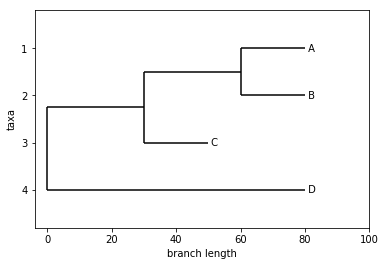

In [42]:
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
tree = Phylo.read(StringIO('(((A:20, B:20):30,C:20):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../Data/Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0007.faa.aln.nwk', 'newick')
# Phylo.draw(tree)
# tree.root_with_outgroup('A', outgroup_branch_length=10e-8)
# C = next(tree.find_elements('C'))
# C.branch_length = 40
# tree.root_with_outgroup('MAL')
# noi = next(tree.find_elements('PV22'))
# noi.branch_length += 20
Phylo.draw(tree)

In [47]:
tree.format('newick')

'(((A:20.00000,B:20.00000):30.00000,C:20.00000):30.00000,D:80.00000):0.00000;\n'

In [51]:
from io import StringIO

In [52]:
unit_tree = Phylo.read(StringIO(tree.format('newick')), 'newick')
for node in unit_tree.get_terminals() + unit_tree.get_nonterminals():
    if node.branch_length:
        node.branch_length = 1.

In [54]:
unit_tree.format('newick')

'(((A:20.00000,B:20.00000):30.00000,C:20.00000):30.00000,D:80.00000):0.00000;\n'

In [55]:
for node in unit_tree.get_terminals() + unit_tree.get_nonterminals():
    if node.branch_length:
        node.branch_length = 1.

In [56]:
unit_tree.format('newick')

'(((A:1.00000,B:1.00000):1.00000,C:1.00000):1.00000,D:1.00000):0.00000;\n'